# Twitter Sentiment Analysis for Depression with text and emoji

## Importing the required Libraries

In [1]:
# utilities
import re
import pickle
import numpy as np
import pandas as pd

# plotting
import seaborn as sns
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# nltk
from nltk.stem import WordNetLemmatizer

# sklearn
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, classification_report

In [2]:
# Importing the dataset
DATASET_COLUMNS  = ["sentiment", "ids", "date", "flag", "user", "text"]
DATASET_ENCODING = "ISO-8859-1"
dataset = pd.read_csv('C:\\Users\Ayush\OneDrive\Documents\Code\DataSpell\Twitter Sentiment Analysis\sentiment140.csv', encoding=DATASET_ENCODING , names=DATASET_COLUMNS)
dataset.head(10)

,sentiment,ids,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."
5,0,1467811372,Mon Apr 06 22:20:00 PDT 2009,NO_QUERY,joy_wolf,@Kwesidei not the whole crew
6,0,1467811592,Mon Apr 06 22:20:03 PDT 2009,NO_QUERY,mybirch,Need a hug
7,0,1467811594,Mon Apr 06 22:20:03 PDT 2009,NO_QUERY,coZZ,@LOLTrish hey long time no see! Yes.. Rains a...
8,0,1467811795,Mon Apr 06 22:20:05 PDT 2009,NO_QUERY,2Hood4Hollywood,@Tatiana_K nope they didn't have it
9,0,1467812025,Mon Apr 06 22:20:09 PDT 2009,NO_QUERY,mimismo,@twittera que me muera ?


In [3]:
# Removing the unnecessary columns.
dataset = dataset[['sentiment','text']]
# Replacing the values to ease understanding.
dataset['sentiment'] = dataset['sentiment'].replace(4,1)
dataset.head(10)

,sentiment,text
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,is upset that he can't update his Facebook by ...
2,0,@Kenichan I dived many times for the ball. Man...
3,0,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all...."
5,0,@Kwesidei not the whole crew
6,0,Need a hug
7,0,@LOLTrish hey long time no see! Yes.. Rains a...
8,0,@Tatiana_K nope they didn't have it
9,0,@twittera que me muera ?


In [4]:
dataset.shape

(1600000, 2)

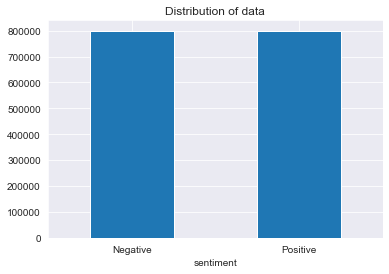

In [5]:
# Plotting the distribution for dataset.
ax = dataset.groupby('sentiment').count().plot(kind='bar', title='Distribution of data',
                                               legend=False)
ax.set_xticklabels(['Negative','Positive'], rotation=0)

# Storing data in lists.
text, sentiment = list(dataset['text']), list(dataset['sentiment'])

# Text Pre-processing

In [6]:
# Defining dictionary containing all emojis with their meanings.
emojis = {':)': 'smile', ':-)': 'smile', ';d': 'wink', ':-E': 'vampire', ':(': 'sad',
          ':-(': 'sad', ':-<': 'sad', ':P': 'raspberry', ':O': 'surprised',
          ':-@': 'shocked', ':@': 'shocked',':-$': 'confused', ':\\': 'annoyed',
          ':#': 'mute', ':X': 'mute', ':^)': 'smile', ':-&': 'confused', '$_$': 'greedy',
          '@@': 'eyeroll', ':-!': 'confused', ':-D': 'smile', ':-0': 'yell', 'O.o': 'confused',
          '<(-_-)>': 'robot', 'd[-_-]b': 'dj', ":'-)": 'sadsmile', ';)': 'wink',
          ';-)': 'wink', 'O:-)': 'angel','O*-)': 'angel','(:-D': 'gossip', '=^.^=': 'cat'}

## Defining set containing all stopwords in english.
stopwordlist = ['a', 'about', 'above', 'after', 'again', 'ain', 'all', 'am', 'an',
                'and','any','are', 'as', 'at', 'be', 'because', 'been', 'before',
                'being', 'below', 'between','both', 'by', 'can', 'd', 'did', 'do',
                'does', 'doing', 'down', 'during', 'each','few', 'for', 'from',
                'further', 'had', 'has', 'have', 'having', 'he', 'her', 'here',
                'hers', 'herself', 'him', 'himself', 'his', 'how', 'i', 'if', 'in',
                'into','is', 'it', 'its', 'itself', 'just', 'll', 'm', 'ma',
                'me', 'more', 'most','my', 'myself', 'now', 'o', 'of', 'on', 'once',
                'only', 'or', 'other', 'our', 'ours','ourselves', 'out', 'own', 're',
                's', 'same', 'she', "shes", 'should', "shouldve",'so', 'some', 'such',
                't', 'than', 'that', "thatll", 'the', 'their', 'theirs', 'them',
                'themselves', 'then', 'there', 'these', 'they', 'this', 'those',
                'through', 'to', 'too','under', 'until', 'up', 've', 'very', 'was',
                'we', 'were', 'what', 'when', 'where','which','while', 'who', 'whom',
                'why', 'will', 'with', 'won', 'y', 'you', "youd","youll", "youre",
                "youve", 'your', 'yours', 'yourself', 'yourselves']

In [7]:
def preprocess(textdata):
    processedText = []

    # Create Lemmatizer and Stemmer.
    wordLemm = WordNetLemmatizer()

    # Defining regex patterns.
    urlPattern        = r"((http://)[^ ]*|(https://)[^ ]*|( www\.)[^ ]*)"
    userPattern       = '@[^\s]+'
    alphaPattern      = "[^a-zA-Z0-9]"
    sequencePattern   = r"(.)\1\1+"
    seqReplacePattern = r"\1\1"

    for tweet in textdata:
        tweet = tweet.lower()

        # Replace all URls with 'URL'
        tweet = re.sub(urlPattern,' URL',tweet)
        # Replace all emojis.
        for emoji in emojis.keys():
            tweet = tweet.replace(emoji, "EMOJI" + emojis[emoji])
            # Replace @USERNAME to 'USER'.
        tweet = re.sub(userPattern,' USER', tweet)
        # Replace all non alphabets.
        tweet = re.sub(alphaPattern, " ", tweet)
        # Replace 3 or more consecutive letters by 2 letter.
        tweet = re.sub(sequencePattern, seqReplacePattern, tweet)

        tweetwords = ''
        for word in tweet.split():
            # Checking if the word is a stopword.
            #if word not in stopwordlist:
            if len(word)>1:
                # Lemmatizing the word.
                word = wordLemm.lemmatize(word)
                tweetwords += (word+' ')

        processedText.append(tweetwords)

    return processedText

In [8]:
import time
import nltk
nltk.download('wordnet')
nltk.download('omw-1.4')

t = time.time()
processedtext = preprocess(text)
print(f'Text Preprocessing complete.')
print(f'Time Taken: {round(time.time()-t)} seconds')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Ayush\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\Ayush\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


Text Preprocessing complete.
Time Taken: 179 seconds


### Word Cloud for Negative tweets

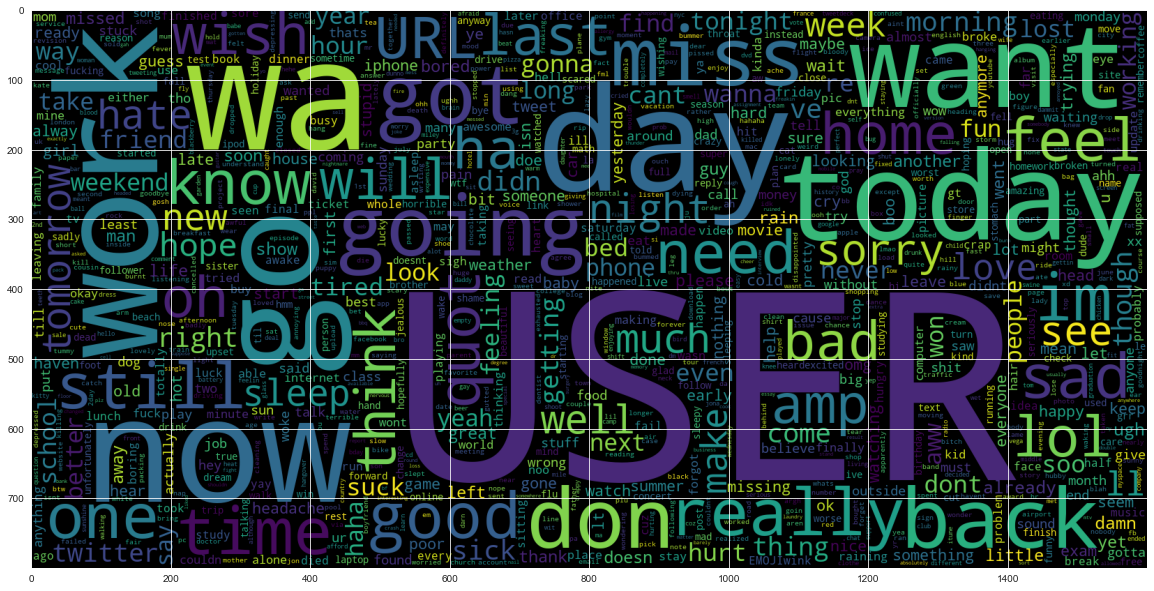

In [12]:
data_neg = processedtext[:800000]
plt.figure(figsize = (20,20))
wc = WordCloud(max_words = 1000 , width = 1600 , height = 800,
               collocations=False).generate(" ".join(data_neg))
plt.imshow(wc)

### Word Cloud for Positive tweets

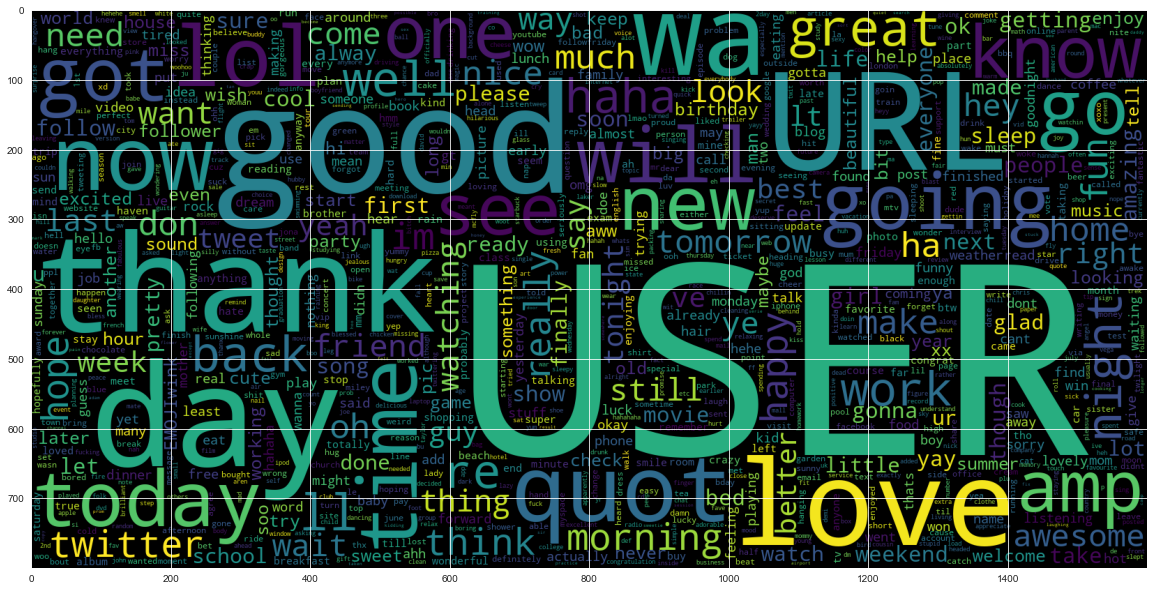

In [13]:
data_pos = processedtext[800000:]
wc = WordCloud(max_words = 1000 , width = 1600 , height = 800,
               collocations=False).generate(" ".join(data_pos))
plt.figure(figsize = (20,20))
plt.imshow(wc)

## Splitting the dataset into Test-Train sets

In [9]:
X_train, X_test, y_train, y_test = train_test_split(processedtext, sentiment, test_size = 0.05, random_state = 1, shuffle=True)
print('Data Split done.')

Data Split done.


## TF-IDF Vectoriser

In [11]:
vectoriser = TfidfVectorizer(ngram_range=(1,2), max_features=3200000)
vectoriser.fit(X_train)
print(f'Vectoriser fitted.')
print('No. of feature_words: ', len(vectoriser.get_feature_names_out()))

Vectoriser fitted.
No. of feature_words:  3200000


## Transforming the dataset

In [12]:
X_train = vectoriser.transform(X_train)
X_test  = vectoriser.transform(X_test)
print(f'Data Transformed.')

Data Transformed.


# Creating and Evaluating Models

In [13]:
def model_Evaluate(model):

    # Predict values for Test dataset
    y_pred = model.predict(X_test)

    # Print the evaluation metrics for the dataset.
    print(classification_report(y_test, y_pred))

    # Compute and plot the Confusion matrix
    cf_matrix = confusion_matrix(y_test, y_pred)

    categories  = ['Negative','Positive']
    group_names = ['True Neg','False Pos', 'False Neg','True Pos']
    group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]

    labels = [f'{v1}\n{v2}' for v1, v2 in zip(group_names,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)

    sns.heatmap(cf_matrix, annot = labels, cmap = 'Blues',fmt = '',
                xticklabels = categories, yticklabels = categories)

    plt.xlabel("Predicted values", fontdict = {'size':14}, labelpad = 10)
    plt.ylabel("Actual values"   , fontdict = {'size':14}, labelpad = 10)
    plt.title ("Confusion Matrix", fontdict = {'size':18}, pad = 20)

# Bernoulli Naive Bayes Model

              precision    recall  f1-score   support

           0       0.80      0.80      0.80     39839
           1       0.80      0.81      0.80     40161

    accuracy                           0.80     80000
   macro avg       0.80      0.80      0.80     80000
weighted avg       0.80      0.80      0.80     80000



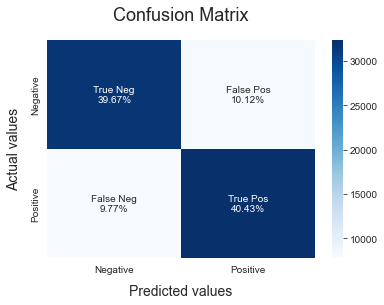

In [14]:
BNBmodel = BernoulliNB(alpha = 2)
BNBmodel.fit(X_train, y_train)
model_Evaluate(BNBmodel)

## Linear SVC

              precision    recall  f1-score   support

           0       0.82      0.82      0.82     39839
           1       0.82      0.82      0.82     40161

    accuracy                           0.82     80000
   macro avg       0.82      0.82      0.82     80000
weighted avg       0.82      0.82      0.82     80000



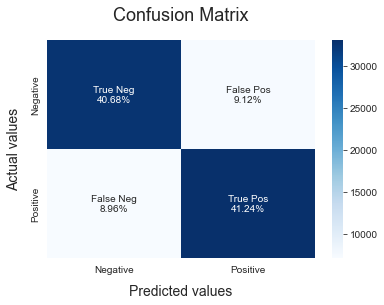

In [15]:
SVCmodel = LinearSVC()
SVCmodel.fit(X_train, y_train)
model_Evaluate(SVCmodel)

## Logistic Regression Model

              precision    recall  f1-score   support

           0       0.83      0.81      0.82     39839
           1       0.82      0.83      0.82     40161

    accuracy                           0.82     80000
   macro avg       0.82      0.82      0.82     80000
weighted avg       0.82      0.82      0.82     80000



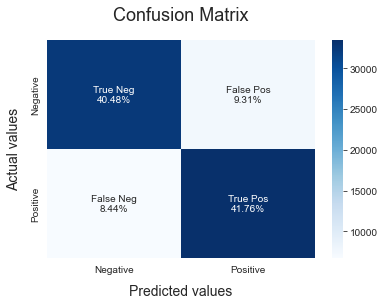

In [16]:
LRmodel = LogisticRegression(C = 2, n_jobs=-1)
LRmodel.fit(X_train, y_train)
model_Evaluate(LRmodel)

## XGB Classifier

In [13]:
from xgboost import XGBClassifier
xgbc = XGBClassifier(
    booster='gbtree',
    learning_rate=0.1,
    max_depth=12,
    n_estimators=3000,
    objective='binary:logistic',
    eval_metric=['auc', "rmse"],
    early_stopping_rounds=75,
    verbosity=2,
    n_jobs=-1,
)
xgbc

XGBClassifier(base_score=None, booster='gbtree', callbacks=None,
       colsample_bylevel=None, colsample_bynode=None,
       colsample_bytree=None, early_stopping_rounds=75,
       enable_categorical=False, eval_metric=['auc', 'rmse'], gamma=None,
       gpu_id=None, grow_policy=None, importance_type=None,
       interaction_constraints=None, learning_rate=0.1, max_bin=None,
       max_cat_to_onehot=None, max_delta_step=None, max_depth=12,
       max_leaves=None, min_child_weight=None, missing=nan,
       monotone_constraints=None, n_estimators=3000, n_jobs=-1,
       num_parallel_tree=None, objective='binary:logistic', predictor=None,
       random_state=None, reg_alpha=None, reg_lambda=None,
       sampling_method=None, scale_pos_weight=None, subsample=None,
       tree_method=None, use_label_encoder=False, validate_parameters=None,
       verbosity=2)

In [ ]:
xgbc.fit(X_train, y_train, eval_set=[(X_train, y_train),(X_test, y_test)])

In [ ]:
y_pred = xgbc.predict(X_train)
predictions = [round(i) for i  in y_pred]
predictions

In [19]:
from sklearn.metrics import f1_score
f1_score(y_train, y_pred)

0.8807338857482123

In [21]:
from sklearn.metrics import accuracy_score
ac_score = accuracy_score(y_train, predictions)
print(ac_score)

0.8784144736842106


In [29]:
cf_matrix1=confusion_matrix(y_train, predictions)
cf_matrix1

array([[652815, 107346],
       [ 77464, 682375]])

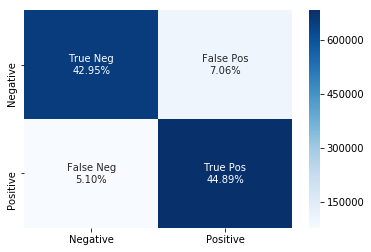

In [33]:
categories  = ['Negative','Positive']
group_names = ['True Neg','False Pos', 'False Neg','True Pos']
group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix1.flatten() / np.sum(cf_matrix1)]

labels = [f'{v1}\n{v2}' for v1, v2 in zip(group_names,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix1, annot = labels, cmap = 'Blues',fmt = '',
                xticklabels = categories, yticklabels = categories)

In [23]:
from xgboost import XGBClassifier
xgbc1 = XGBClassifier(
    booster='gbtree',
    learning_rate=0.05,
    max_depth=14,
    min_child_weight=6,
    subsample=0.8,
    n_estimators=4000,
    objective='binary:logistic',
    eval_metric=['auc', "rmse"],
    early_stopping_rounds=75,
    verbosity=2,
    n_jobs=-1,
    reg_alpha=1e-5,
    reg_lambda=1,
)
xgbc1

XGBClassifier(base_score=None, booster='gbtree', callbacks=None,
       colsample_bylevel=None, colsample_bynode=None,
       colsample_bytree=None, early_stopping_rounds=75,
       enable_categorical=False, eval_metric=['auc', 'rmse'], gamma=None,
       gpu_id=None, grow_policy=None, importance_type=None,
       interaction_constraints=None, learning_rate=0.05, max_bin=None,
       max_cat_to_onehot=None, max_delta_step=None, max_depth=14,
       max_leaves=None, min_child_weight=6, missing=nan,
       monotone_constraints=None, n_estimators=4000, n_jobs=-1,
       num_parallel_tree=None, objective='binary:logistic', predictor=None,
       random_state=None, reg_alpha=1e-05, reg_lambda=1,
       sampling_method=None, scale_pos_weight=None, subsample=0.8,
       tree_method=None, use_label_encoder=False, validate_parameters=None,
       verbosity=2)

In [ ]:
xgbc1.fit(X_train, y_train, eval_set=[(X_train, y_train),(X_test, y_test)])

In [ ]:
y_pred1 = xgbc1.predict(X_train)
predictions1 = [round(i) for i  in y_pred1]
predictions1

In [26]:
from sklearn.metrics import f1_score
f1_score(y_train, y_pred1)

0.859141455796841

In [27]:
from sklearn.metrics import accuracy_score
ac_score1 = accuracy_score(y_train, predictions1)
print(ac_score1)

0.8566315789473684


In [34]:
cf_matrix2=confusion_matrix(y_train, predictions1)
cf_matrix2

array([[637498, 122663],
       [ 95257, 664582]])

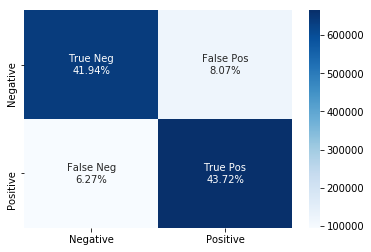

In [35]:
categories  = ['Negative','Positive']
group_names = ['True Neg','False Pos', 'False Neg','True Pos']
group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix2.flatten() / np.sum(cf_matrix2)]

labels = [f'{v1}\n{v2}' for v1, v2 in zip(group_names,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix2, annot = labels, cmap = 'Blues',fmt = '',
                xticklabels = categories, yticklabels = categories)